In [1]:
# O bi sempre executa isso aqui antes de começar:
# dataset = pandas.DataFrame(field1,field2,field3,...,fieldN)
# dataset = dataset.drop_duplicates()

from pandas import read_csv,DataFrame,melt
from scipy import stats
from scipy.stats import kurtosis,skew
import numpy as np
import seaborn as sns
from matplotlib.pyplot import tight_layout,subplots,show
from sklearn.preprocessing import StandardScaler,MaxAbsScaler,PowerTransformer
from blume import table

In [2]:
import dtale
%matplotlib inline

############################## exclusivo debug: ####################################################
idxName = ['id']
#catFList = ['f_27']
catFList = ['f_27',"f_07","f_08","f_09","f_10","f_11","f_12"]
#discFList = ["f_07","f_08","f_09","f_10","f_11","f_12","f_13","f_14","f_15","f_16","f_17","f_18","f_29","f_30"]
discFList = ["f_13","f_14","f_15","f_16","f_17","f_18","f_29","f_30"]
tgtFList = ["target"]
fileDir = "D:\\Projetos\\competicoes\\featureOps\\data\\tabular-playground-series-may-2022\\train.csv"
featureDF = read_csv(fileDir)
featureDF.set_index(idxName[0],inplace=True,drop=False)
numFList = list(set(featureDF.columns) - set(tgtFList) - set(discFList) - set(catFList))
numDF = featureDF.sample(n=1000,random_state=1111)
dataset = melt(numDF, id_vars = idxName + catFList, value_vars=numFList+discFList,value_name='numfeatures')
dataset = dataset[dataset['variable']=='f_06']

isCorrel = True

#### mudança do melt para o tabular : ####
if isCorrel:
    dataset = numDF[numFList]

#x = dataset.copy()
#x.drop(columns=['id'],inplace=True)
#d = dtale.show(x)
#print(d._url)
#d.open_browser()

#recomendacoes:
#By default, Power BI loads pandas, matplotlib and os, no need to re-import it (import pandas as pd). If you do need to alias the package, create a variable, pd=pandas and then you can use pd.read_csv(..)

findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


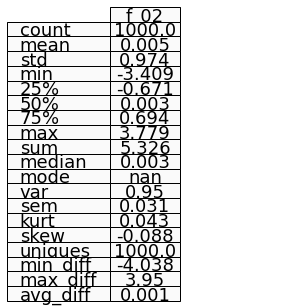

In [3]:
def openTwoFeats():

    file = open("D:\\Projetos\\competicoes\\featureOps\\data\\dashboards\\biExports\\f1.csv")
    lines = file.readlines()
    f1 = ''.join(string for string in lines[1] if string.isprintable())
    file.close()

    file = open("D:\\Projetos\\competicoes\\featureOps\\data\\dashboards\\biExports\\f2.csv")
    lines = file.readlines()
    f2 = ''.join(string for string in lines[1] if string.isprintable())
    file.close()

    return f1,f2

f1,f2 = openTwoFeats()
dataset = dataset[[f1,f2]]

############# LOCAL FLOW : ############################################################
graph_type = 'scatter' #'histogram','qqplot','boxplot','table','heatcorrel','scatter'
transform_flag = False #uso especifico da aba com transformações
var_grafico = f1
## posicao: width etc.. 
## olhar a api do bi javascript
#######################################################################################

def readSlicer(filename):

    #csv com exatamente 2 linhas, pode dar problema ser o utf, encoding etc for diferente.

    filePath = ("D:\\Projetos\\competicoes\\featureOps\\data\\dashboards\\biExports\\" + filename)
    file = open(filePath)
    lines = file.readlines()
    selSlice = ''.join(string for string in lines[1] if string.isprintable())
    file.close()

    return selSlice


#######################################################################################

def graph_transf(f1):

    global dataset

    transformers = readSlicer("transformers.csv")
    transDic = {'StandardScaler':StandardScaler(),'MaxAbsScaler':MaxAbsScaler(),'PowerTransformer':PowerTransformer()} #colocar aqui os suportados
    scaler = transDic[transformers]
    scaler.fit(dataset[[f1]])
    dataset = DataFrame(scaler.transform(dataset[[f1]]),columns=[f1])
    
    return None

def graph_hist(f1):

    global dataset

    binsLen = int(round(len(dataset) ** (1/2),0))
    graph = sns.histplot(data=dataset[f1],bins=binsLen,kde=True)
    graph.set(title=str(f1)+' Frequency Distribuiton')
    graph.set_xlabel("Bins")
    graph.set_ylabel("Frequency")

def graph_scatter(placeholder):

    global dataset

    sns.scatterplot(data=dataset, x=f1, y=f2)


def graph_table(f1):

    global dataset

    dataset = dataset[[f1]]
    statsx = dataset.describe().T

    ###extras:
    statsx['sum'] = dataset[f1].sum()
    statsx['median'] = dataset[f1].median()
    mode = dataset[f1].mode().values
    statsx['mode'] = np.nan if len(mode) > 1 else mode[0]
    statsx['var'] = dataset[f1].var()
    statsx['sem'] = dataset[f1].sem()
    statsx['kurt'] = kurtosis(dataset[f1])
    statsx['skew'] = skew(dataset[f1])
    statsx['uniques'] = dataset[f1].nunique()

    sequential_diffs = dataset[f1].diff() #"pulo" entre rows
    sequential_diffs.sort_values(ascending=False,inplace=True)
    statsx['min_diff']= sequential_diffs.min()
    statsx['max_diff']= sequential_diffs.max()
    statsx['avg_diff'] = sequential_diffs.mean()

    statsx = statsx.T
    statsx[f1] = round(statsx[f1],3)

    uniq_vals = dataset[f1].value_counts()

    fig, ax = subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    ax.figure.set_size_inches(4, 4)

    #cores da tabela:
    colors_cell = [['#FAFAFA']]*len(statsx)
    colors_rows = ['#FAFAFA']*len(statsx)
    colors_cols = ['#FAFAFA']

    #inferno na terra (formatacao da tabela com o matplotlib):
    #talvez formatar por celula, for i in cells, seja melhor
    tablex = table.table(ax,cellText=statsx.values, colLabels=statsx.columns,rowLabels=statsx.index,cellLoc='center',loc='center'
                        ,colWidths = [0.25],cellColours=colors_cell,rowColours=colors_rows,colColours=colors_cols)
    tablex.auto_set_font_size(False)
    tablex.set_fontsize(14)
    tablex.scale(0.9,1.3) #(COLUMN,ROW)

def graph_qqplot(f1):

    global dataset
    stats.probplot(dataset[f1], plot=sns.mpl.pyplot)


def graph_boxplot(placeholder):

    global dataset
    global f1,f2
    sns.boxplot(data=dataset,orient='vertical')


############## GLOBAL FLOW : ##########################################################
possibleGraphs = {'histogram':graph_hist,'qqplot':graph_qqplot,'boxplot':graph_boxplot,'table':graph_table,'scatter':graph_scatter}
#######################################################################################

graph_transf(f1) if transform_flag else None
possibleGraphs[graph_type](var_grafico)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
tight_layout(pad=0, w_pad=0, h_pad=0)
show()